<center>
<img src="../../ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm_notebook
import pickle as pkl
from collections import defaultdict
import xgboost as xgb

Reading original data

In [2]:
PATH_TO_DATA = ('./data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
site_dict = pkl.load(open('./data/site_dic.pkl', 'rb'))
site_dict_inv = defaultdict(str, [(v, k) for (k, v) in site_dict.items()])

In [4]:
train_df.sort_values(by='time1', inplace=True)

In [5]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

Separate target feature 

In [7]:
y = train_df['target']

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [7]:
X = train_df.drop('target', axis=1)
test = test_df.copy()

In [8]:
times = ['time%s' % i for i in np.arange(1, 11)]
sites = ['site%s' % i for i in np.arange(1, 11)]

In [9]:
X[times] = X[times].fillna(0).apply(pd.to_datetime)
test[times] = test[times].fillna(0).apply(pd.to_datetime)

In [10]:
X[sites] = X[sites].fillna(0).astype('int')
test[sites] = test[sites].fillna(0).astype('int')

In [11]:
for i in tqdm_notebook(np.arange(1, 11)):
    X['site_name%s' % i] = X['site%s' % i].apply(lambda i: ' '.join(site_dict_inv[i].split('.')))
    test['site_name%s' % i] = test['site%s' % i].apply(lambda i: ' '.join(site_dict_inv[i].split('.')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [12]:
X.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site_name1,site_name2,site_name3,site_name4,site_name5,site_name6,site_name7,site_name8,site_name9,site_name10
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,safebrowsing clients google com,safebrowsing-cache google com,,,,,,,,
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,safebrowsing clients google com,safebrowsing-cache google com,safebrowsing clients google com,safebrowsing-cache google com,,,,,,
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,www apache org,www apache org,download eclipse org,www apache org,www apache org,www webtide com,download oracle com,javadl-esd-secure oracle com,www caucho com,www apache org
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,www webtide com,download oracle com,www caucho com,download oracle com,www webtide com,www apache org,public dhe ibm com,www webtide com,www apache org,www apache org
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,public dhe ibm com,jope ow2 org,download oracle com,public dhe ibm com,jope ow2 org,master dl sourceforge net,www apache org,download eclipse org,www apache org,public dhe ibm com


In [13]:
X['all_sites'] = [' '.join(row) for row in X[sites].astype(str).values]
test['all_sites'] = [' '.join(row) for row in test[sites].astype(str).values]

In [13]:
site_names = ['site_name%s' % i for i in np.arange(1, 11)]
X_all_sites_names = [(' '.join(row)).strip() for row in X[site_names].values]
test_all_sites_names = [(' '.join(row)).strip() for row in test[site_names].values]

In [14]:
tf_idf = TfidfVectorizer(ngram_range=(1, 7), max_features=100000, max_df=0.5)
tf_idf.fit(X['all_sites'])
X_tfidf = tf_idf.transform(X['all_sites'])
test_tfidf = tf_idf.transform(test['all_sites'])

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [15]:
def get_day_part(time):
    h = time.hour
    if h < 12:
        return 1
    elif h < 20:
        return 2
    else:
        return 3

X['day_part'] = X['time1'].apply(get_day_part)
test['day_part'] = test['time1'].apply(get_day_part)

In [89]:
alice_hour = ['12', '13', '16', '17', '18']

X['day_part_alice'] = [int(row.hour in alice_hour) for row in
                                         tqdm_notebook(X['time1'])]
test['day_part_alice'] = [int(row.hour in alice_hour) for row in
                                         tqdm_notebook(test['time1'])]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [15]:
def make_harmonic_features_cos(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.cos(value)

def make_harmonic_features_sin(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.sin(value)

hour_coses = ['hour_cos%s' % i for i in np.arange(1, 11)]
hour_sins = ['hour_sin%s' % i for i in np.arange(1, 11)]
hour = ['hour%s' % i for i in np.arange(1, 11)]

for i in tqdm_notebook(np.arange(1, 11)):
    X['hour%s' % i] = X['time%s' % i].apply(lambda x: x.hour)
    # X['hour_cos%s' % i] = X['time%s' % i].apply(make_harmonic_features_cos)
    # X['hour_sin%s' % i] = X['time%s' % i].apply(make_harmonic_features_sin)
    test['hour%s' % i] = test['time%s' % i].apply(lambda x: x.hour)
    # test['hour_cos%s' % i] = test['time%s' % i].apply(make_harmonic_features_cos)
    # test['hour_sin%s' % i] = test['time%s' % i].apply(make_harmonic_features_sin)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [68]:
X['unique_sites'] = [np.unique(row[row != 0]).shape[0] for row in 
                     tqdm_notebook(X[['site' + str(i) for i in np.arange(1, 11)]].values)]
test['unique_sites'] = [np.unique(row[row != 0]).shape[0] for row in 
                         tqdm_notebook(test[['site' + str(i) for i in np.arange(1, 11)]].values)]

X['visited'] = [row[row != 0].shape[0] for row in 
                     tqdm_notebook(X[['site' + str(i) for i in np.arange(1, 11)]].values)]
test['visited'] = [row[row != 0].shape[0] for row in 
                         tqdm_notebook(test[['site' + str(i) for i in np.arange(1, 11)]].values)]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [16]:
def get_duration(row):
    zero = np.datetime64('1970-01-01T00:00:00.000000000')
    cor = [r for r in row if r != zero]
    return (cor[-1] - cor[0])
    
X['duration'] = [get_duration(row) for row in
                     tqdm_notebook(X[['time%s' % i for i in np.arange(1, 11)]].values)]
test['duration'] = [get_duration(row) for row in
                     tqdm_notebook(test[['time%s' % i for i in np.arange(1, 11)]].values)]

X['duration'] = X['duration'].apply(lambda s: int(s.total_seconds()) + 1)
test['duration'] = test['duration'].apply(lambda s: int(s.total_seconds()) + 1)

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [17]:
X['weekday'] = [row.weekday() for row in
                                         tqdm_notebook(X['time1'])]
test['weekday'] = [row.weekday() for row in
                                         tqdm_notebook(test['time1'])]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [101]:
X['year'] = X['time1'].apply(lambda x: x.year)
test['year'] = test['time1'].apply(lambda x: x.year)

In [98]:
X['is_weekend'] = X['month'].apply(lambda x: 1 if x in (5, 6) else 0)
test['is_weekend'] = test['month'].apply(lambda x: 1 if x in (5, 6) else 0)

In [18]:
alice_sites_count = defaultdict(int)
for row in tqdm_notebook(train_df[train_df['target'] == 1][sites].values):
    for site in row:
        alice_sites_count[site] += 1
alice_sites = sorted([(k, v) for (k, v) in alice_sites_count.items()], key=lambda x: x[1], reverse=True)
alice_top_sites = [i[0] for i in alice_sites][:10]

X['visit_top_site'] = X[sites].apply(lambda row: len(list(filter(lambda x: x in alice_top_sites, row))), axis=1)
test['visit_top_site'] = test[sites].apply(lambda row: len(list(filter(lambda x: x in alice_top_sites, row))), axis=1)

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

In [44]:
X['start_hour'] = X['time1'].apply(lambda x: x.hour)
test['start_hour'] = test['time1'].apply(lambda x: x.hour)

In [59]:
def make_harmonic_features_cos_month(month, period=12):
    month -= 1
    month *= 2 * np.pi / period
    return np.cos(month)

def make_harmonic_features_sin_month(month, period=12):
    month -= 1
    month *= 2 * np.pi / period
    return np.sin(month)

X['month'] = X['time1'].apply(lambda x: x.month)
test['month'] = test['time1'].apply(lambda x: x.month)
# X['month_cos'] = X['month'].apply(make_harmonic_features_cos_month)
# test['month_cos'] = test['month'].apply(make_harmonic_features_cos_month)
# X['month_sin'] = X['month'].apply(make_harmonic_features_sin_month)
# test['month_sin'] = test['month'].apply(make_harmonic_features_sin_month)

In [107]:
def make_harmonic_features_cos_weekday(value, period=7):
    value *= 2 * np.pi / period
    return np.cos(value)

def make_harmonic_features_sin_weekday(value, period=7):
    value *= 2 * np.pi / period
    return np.sin(value)

X['weekday_cos'] = X['weekday'].apply(make_harmonic_features_cos_weekday)
test['weekday_cos'] = test['weekday'].apply(make_harmonic_features_cos_weekday)
X['weekday_sin'] = X['weekday'].apply(make_harmonic_features_sin_weekday)
test['weekday_sin'] = test['weekday'].apply(make_harmonic_features_sin_weekday)

In [23]:
X['site_per_sec'] = X[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)
test['site_per_sec'] = test[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)

In [82]:
X['ratio'] = X[['unique_sites', 'visited']].apply(lambda x: x[0] / x[1], axis=1)
test['ratio'] = test[['unique_sites', 'visited']].apply(lambda x: x[0] / x[1], axis=1)

In [284]:
def is_worktime(hour, weekday):
    if (hour >= 9 and hour <= 13) or (hour >= 14 and hour <= 18):
        if weekday != 6:
            return 1
        else:
            return 0
    else:
        return 0
    
X['worktime'] = X[['hour1', 'weekday']].apply(lambda x: is_worktime(x[0], x[1]), axis=1)
test['worktime'] = test[['hour1', 'weekday']].apply(lambda x: is_worktime(x[0], x[1]), axis=1)

In [19]:
def get_yyyymm(time):
    year = time.year
    month = time.month
    if month < 10:
        return str(year) + '0' + str(month)
    else:
        return str(year) + str(month)

X['YYYYMM'] = X['time1'].apply(lambda x: get_yyyymm(x)).astype(int)
test['YYYYMM'] = test['time1'].apply(lambda x: get_yyyymm(x)).astype(int)

In [20]:
X.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,hour5,hour6,hour7,hour8,hour9,hour10,duration,weekday,visit_top_site,YYYYMM
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,0,0,0,0,0,0,1,5,0,201301
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,0,0,0,0,0,0,1787,5,0,201301
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,8,8,8,8,8,8,5,5,0,201301
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,8,8,8,8,8,8,4,5,0,201301
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,8,8,8,8,8,8,3,5,0,201301


In [21]:
X.columns

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'site_name1', 'site_name2',
       'site_name3', 'site_name4', 'site_name5', 'site_name6', 'site_name7',
       'site_name8', 'site_name9', 'site_name10', 'all_sites', 'hour1',
       'hour2', 'hour3', 'hour4', 'hour5', 'hour6', 'hour7', 'hour8', 'hour9',
       'hour10', 'duration', 'weekday', 'visit_top_site', 'YYYYMM'],
      dtype='object')

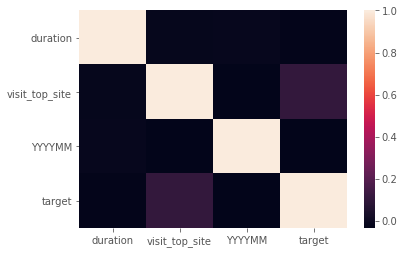

In [22]:
sns.heatmap(pd.concat([X[['duration', 'visit_top_site', 'YYYYMM']], y], axis=1).corr())

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [23]:
ohe = OneHotEncoder()
ohe_columns = ['weekday'] + hour
ohe.fit(X[ohe_columns])
X_ohe = ohe.transform(X[ohe_columns])
test_ohe = ohe.transform(test[ohe_columns])

In [24]:
ss = StandardScaler()
mm = MinMaxScaler()
columns = ['duration', 'visit_top_site', 'YYYYMM']

X_numeric = X[columns]
test_numeric = test[columns]

ss.fit(X_numeric.append(test_numeric))
X_numeric = ss.transform(X_numeric)
test_numeric = ss.transform(test_numeric)

# mm.fit(X_numeric.append(test_numeric))
# X_numeric = mm.transform(X_numeric)
# test_numeric = mm.transform(test_numeric)

In [25]:
pd.DataFrame(X_numeric, columns=columns).describe()

,duration,visit_top_site,YYYYMM
count,253561.000000,253561.000000,253561.000000
mean,0.003731,-0.004081,-0.205333
std,1.008779,0.989884,1.074147
min,-0.468611,-0.648323,-2.079076
25%,-0.444737,-0.648323,-1.800775
50%,-0.376526,-0.648323,0.476232
75%,-0.083219,0.310477,0.501532
max,5.670382,4.145677,0.526832


In [26]:
bin_columns = []
X_binary = X[bin_columns]
test_binary = test[bin_columns]

In [27]:
X_at_all = hstack([X_tfidf, X_binary, X_numeric, X_ohe]).tocsr()
test_at_all = hstack([test_tfidf, test_binary, test_numeric, test_ohe]).tocsr()

Perform cross-validation with logistic regression.

In [43]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.7):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    # lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    lr = xgb.XGBClassifier(random_state=seed, nthread=-1, reg_lambda=C).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = lr.predict_proba(X[idx:, :])[:, 1]
    y_pred_train = lr.predict_proba(X[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [44]:
%%time
print(get_auc_lr_valid(X_at_all, y))

(0.9814653132116806, 0.95826416080158)
CPU times: user 1min 34s, sys: 1.68 s, total: 1min 36s
Wall time: 28.7 s


In [45]:
train_score = []
val_score = []
C = [0.0001, 0.001, 0.01, 1, 2]
for c in tqdm_notebook(C):
    score = get_auc_lr_valid(X_at_all, y, C=c, ratio=0.7)
    train_score.append(score[0])
    val_score.append(score[1])

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Text(0.5,0,'C')

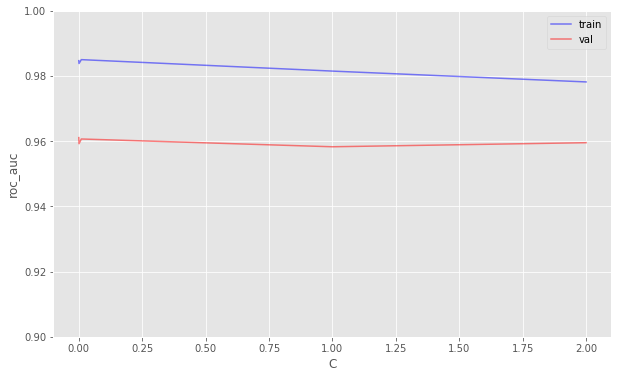

In [46]:
(fig, ax) = plt.subplots(figsize=(10, 6))
ax.plot(C, train_score, alpha=0.5, color='blue', label='train')
ax.plot(C, val_score, alpha=0.5, color='red', label='val')
ax.legend(loc='best')
ax.set_ylim([0.9,1])
ax.set_ylabel('roc_auc')
ax.set_xlabel('C')

In [47]:
list(zip(zip(C, train_score), zip(C, val_score)))

[((0.0001, 0.9846628120384249), (0.0001, 0.9610679492515437)),
 ((0.001, 0.9837904200827943), (0.001, 0.9592025929911355)),
 ((0.01, 0.9849786760031856), (0.01, 0.9606464265483818)),
 ((1, 0.9814653132116806), (1, 0.95826416080158)),
 ((2, 0.9781435212932129), (2, 0.959510794795158))]

In [332]:
%time
clf = LogisticRegression(random_state=17, n_jobs=-1, C=2)
clf.fit(X_at_all, y)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
%time
clf = xgb.XGBClassifier(random_state=17, nthread=-1, reg_lambda=0.0001)
clf.fit(X_at_all, y)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=17,
       reg_alpha=0, reg_lambda=0.0001, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Make prediction for the test set and form a submission file.

In [49]:
test_pred = clf.predict_proba(test_at_all)

In [50]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [51]:
write_to_submission_file(test_pred[:, 1],
                         './submissions/tfidf1-7-numbers+ss+regl1e-3_xgboost.csv')

## boosting

In [189]:
import xgboost as xgb
import catboost

In [237]:
X_boost = X[hour + ['weekday', 'duration']]
test_boost = test[hour + ['weekday', 'duration']]

# X_boost = pd.DataFrame(hstack([X_ohe, X_numeric]).todense())
# test_boost = pd.DataFrame(hstack([test_ohe, test_numeric]).todense())

In [238]:
cat_features = list(np.arange(0, X_boost.shape[1] - 1))

In [239]:
def get_auc_lr_valid_xgb(X, y, n_estimators=100, seed=17, ratio=0.7, cat_features=[]):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    # clf = xgb.XGBClassifier(booster='gblinear', n_jobs=-1, random_state=seed)
    clf = catboost.CatBoostClassifier(random_seed=seed, n_estimators=n_estimators)
    clf.fit(X.iloc[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = clf.predict_proba(X.iloc[idx:, :])[:, 1]
    y_pred_train = clf.predict_proba(X.iloc[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [240]:
%%time
get_auc_lr_valid_xgb(X_boost, y, cat_features=cat_features)

0:	learn: 0.6063719	total: 68.2ms	remaining: 6.75s
1:	learn: 0.5321133	total: 140ms	remaining: 6.84s
2:	learn: 0.4643030	total: 209ms	remaining: 6.75s
3:	learn: 0.4079009	total: 285ms	remaining: 6.85s
4:	learn: 0.3594168	total: 358ms	remaining: 6.81s
5:	learn: 0.3178158	total: 436ms	remaining: 6.83s
6:	learn: 0.2821433	total: 522ms	remaining: 6.94s
7:	learn: 0.2515467	total: 606ms	remaining: 6.96s
8:	learn: 0.2253346	total: 691ms	remaining: 6.99s
9:	learn: 0.2027370	total: 782ms	remaining: 7.03s
10:	learn: 0.1832683	total: 852ms	remaining: 6.89s
11:	learn: 0.1664569	total: 923ms	remaining: 6.77s
12:	learn: 0.1519037	total: 1.02s	remaining: 6.83s
13:	learn: 0.1392777	total: 1.09s	remaining: 6.67s
14:	learn: 0.1282828	total: 1.16s	remaining: 6.59s
15:	learn: 0.1186869	total: 1.25s	remaining: 6.55s
16:	learn: 0.1102888	total: 1.31s	remaining: 6.42s
17:	learn: 0.1029188	total: 1.39s	remaining: 6.32s
18:	learn: 0.0964337	total: 1.46s	remaining: 6.24s
19:	learn: 0.0907121	total: 1.54s	remain

(0.9463204432424233, 0.9183805230239315)